In [1]:
suppressPackageStartupMessages({

library(tidyverse)
library(glue)
library(here)
library(bdkn)
library(GenomicRanges)
library(rtracklayer)

})

In [2]:
get_coverage <- function(bed, bam) { 
    paste("bedtools coverage -a", bed, "-b", bam, "-d") %>%
        pipe %>%
        read_tsv(col_names = c("chr", "start", "end", "pos", "coverage"),
                 col_types = "ciiii") %>%
        makeGRangesFromDataFrame(starts.in.df.are.0based = TRUE,
                                 keep.extra.columns = TRUE)
}

## Characteristics of three different capture sets

### Exome capture set

In [3]:
bed <- import.bed(here("data/coord/capture_exome.bed"))

In [4]:
length(bed)

[1] 2519

In [5]:
width(bed) %>% sum

[1] 118643

In [6]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0     1.0     3.0    47.1    67.5  1257.0 

### Lippold capture set

In [7]:
bed <- import.bed(here("data/coord/capture_lippold.bed"))

In [8]:
length(bed)

[1] 1251

In [9]:
width(bed) %>% sum

[1] 573657

In [10]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   60.0   119.0   151.0   458.6   820.0  3899.0 

### Full Y chromosome capture set

In [11]:
bed <- import.bed(here("data/coord/capture_full.bed"))

In [12]:
length(bed)

[1] 15906

In [13]:
width(bed) %>% sum

[1] 6913053

In [14]:
width(bed) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   99.0   145.0   240.0   434.6   489.8  9425.0 

# Calculate coverage for all three sets of capture regions

In [15]:
cov_df <-
    list.files(here("data/bam"), ".*.bam$", full.names = TRUE) %>%
    map_dfr(function(bam) {
        name <- basename(bam) %>% str_replace_all("^[a-z]+_|.bam$", "")
        regions <- basename(bam) %>% str_replace_all("^([a-z]+)_.*", "\\1")
        bed <- here(glue("data/coord/capture_{regions}.bed"))
        coverage_df <-
            get_coverage(bed, bam) %>%
            as.data.frame %>%
            mutate(name = name, regions = regions) %>%
            rename("seqnames" = "chrom") %>%
            select(-width, -strand, -pos)
    })

In [16]:
saveRDS(cov_df, here("data/rds/cov_df.rds"))

In [17]:
cov_df %>%
group_by(name, regions) %>%
summarise(avg_coverage = mean(coverage)) %>%
spread(regions, avg_coverage)

name,exome,full,lippold
a00_1,9.938353,9.0721386,9.214063
a00_2,13.434084,12.3524401,12.601209
bichon,4.657241,4.2278051,4.610461
denisova8,NA,3.6038601,NA
elsidron1,3.335300,NA,NA
elsidron2,NA,NA,8.186399
kk1,6.259206,7.0697047,7.452903
loschbour,11.093373,10.9851776,10.257164
mez2,NA,1.5039062,NA
mota,5.621031,6.6815048,6.611744


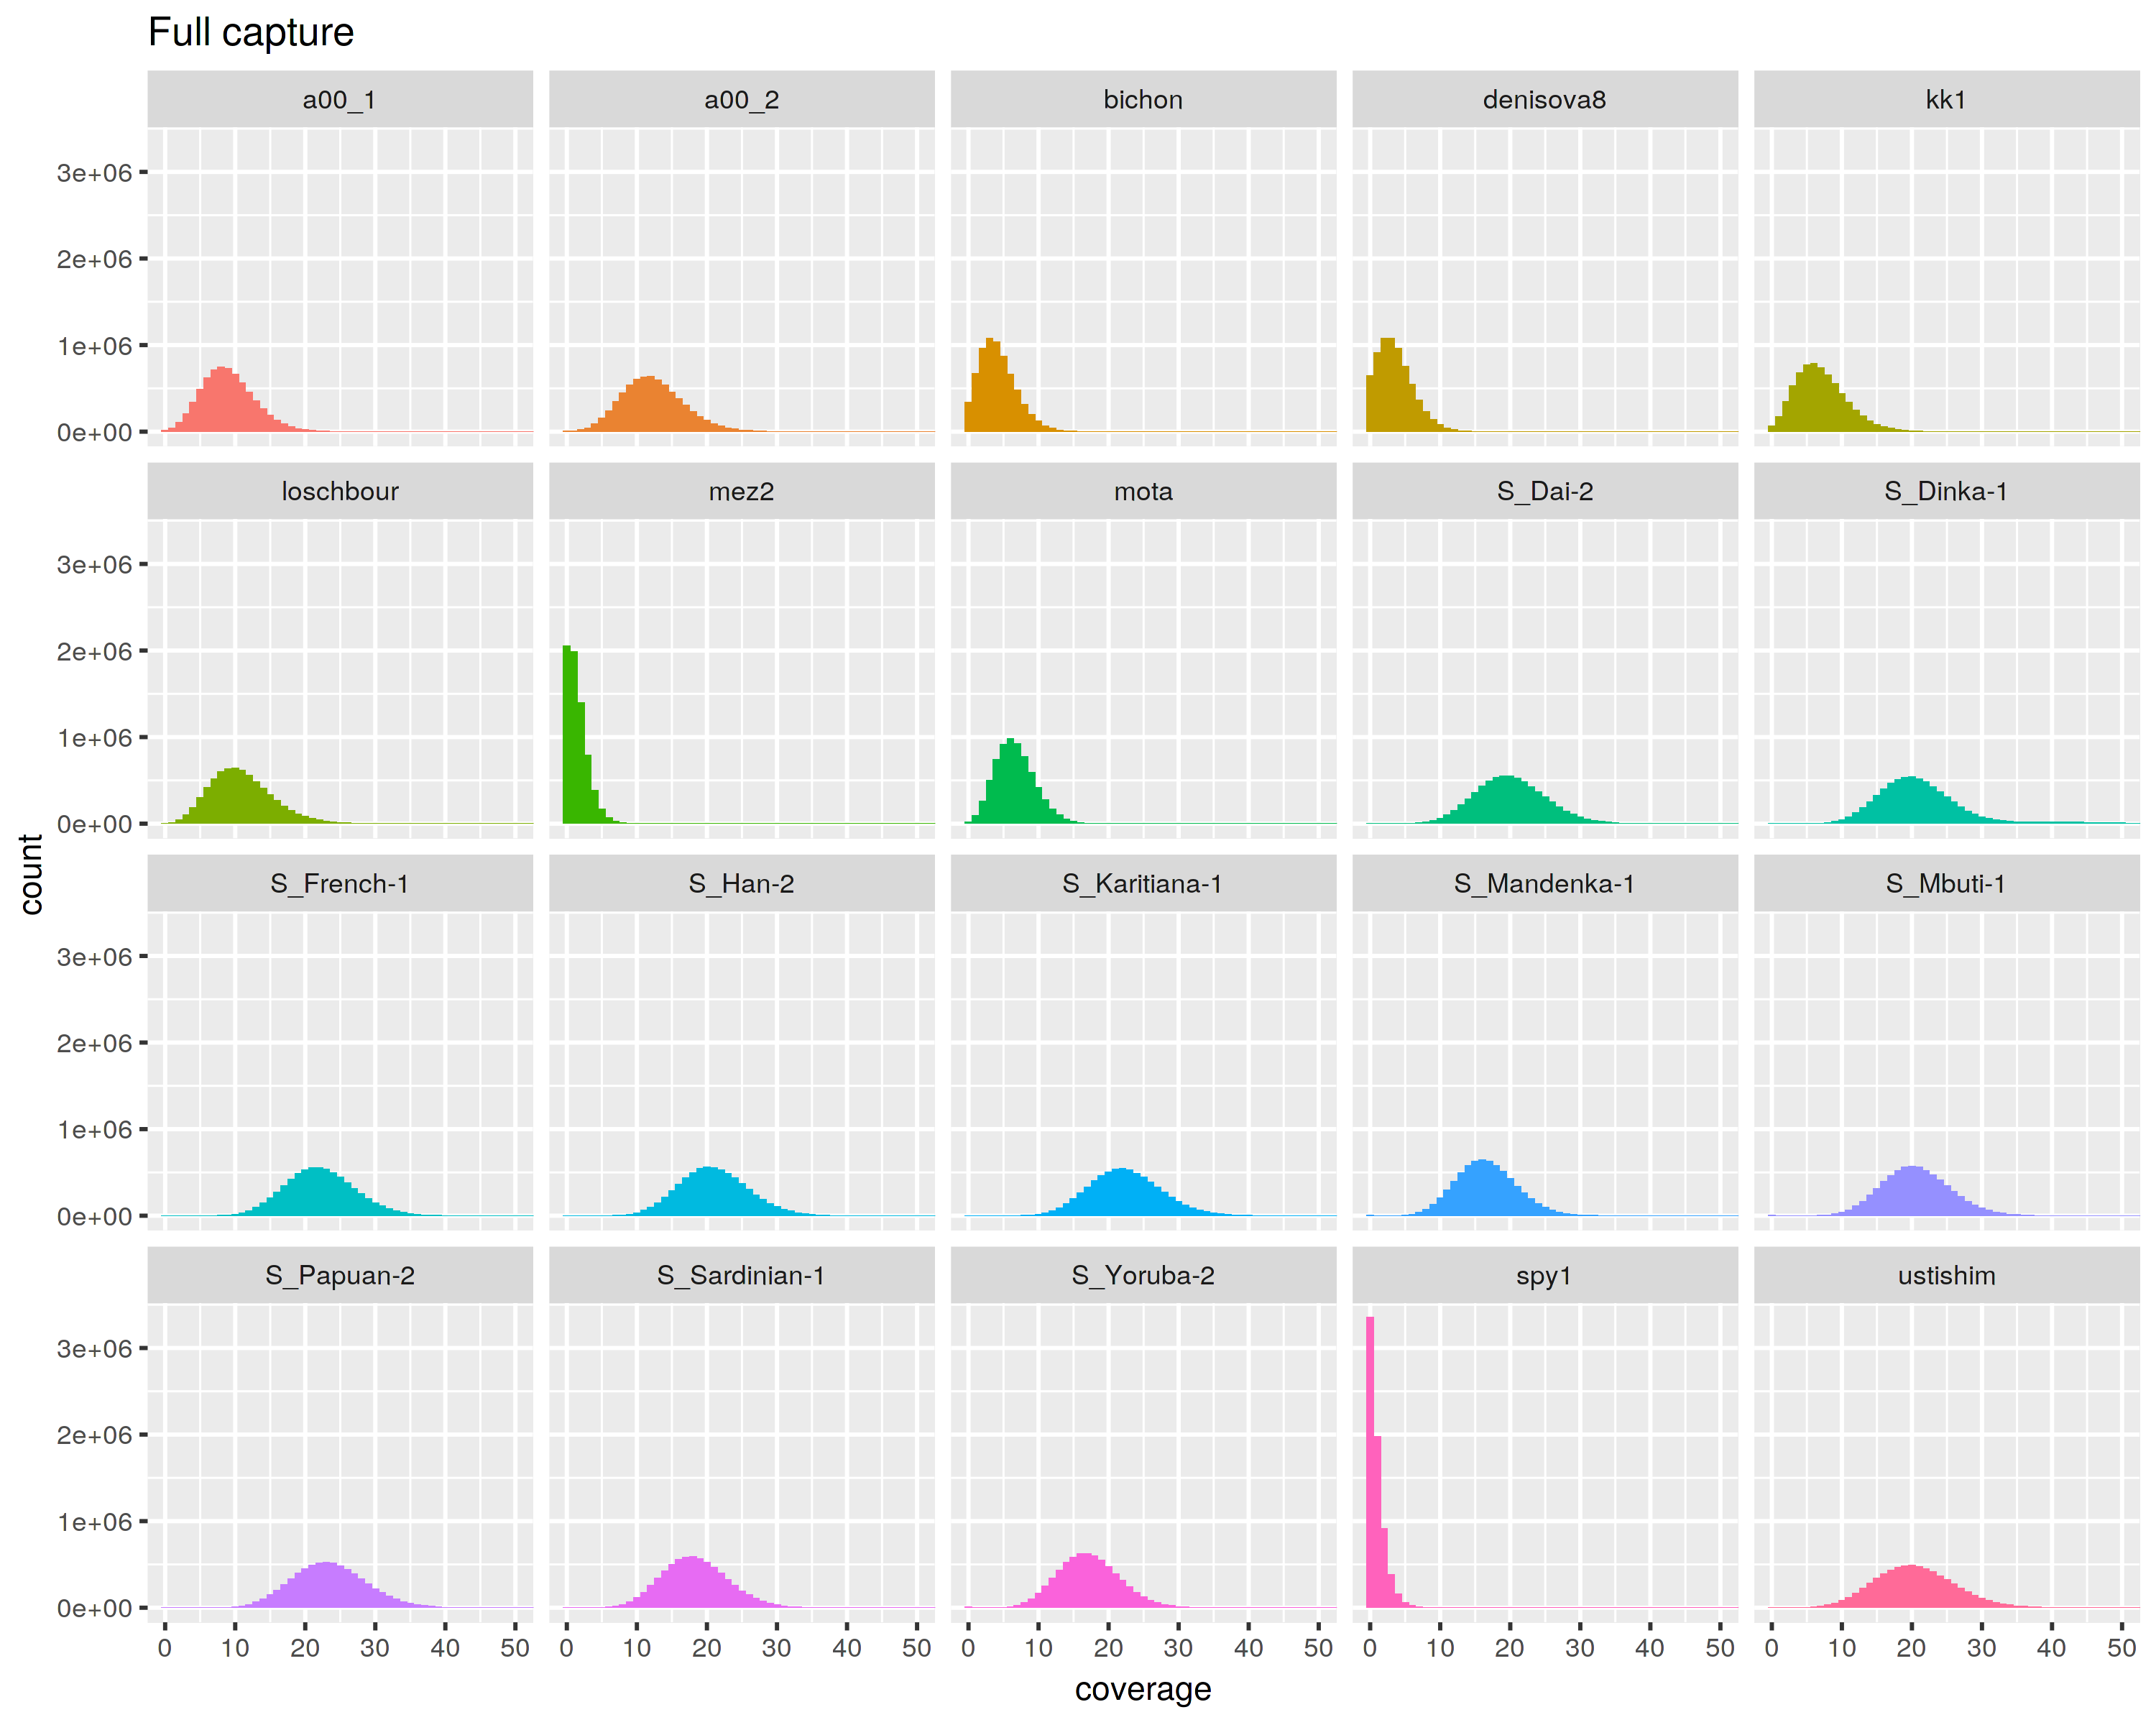

In [18]:
set_dim(10, 8, 300)

cov_df %>%
filter(regions == "full") %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    coord_cartesian(xlim = c(0, 50)) +
    facet_wrap(~ name) +
    theme(legend.position = "none") +
    ggtitle("Full capture")

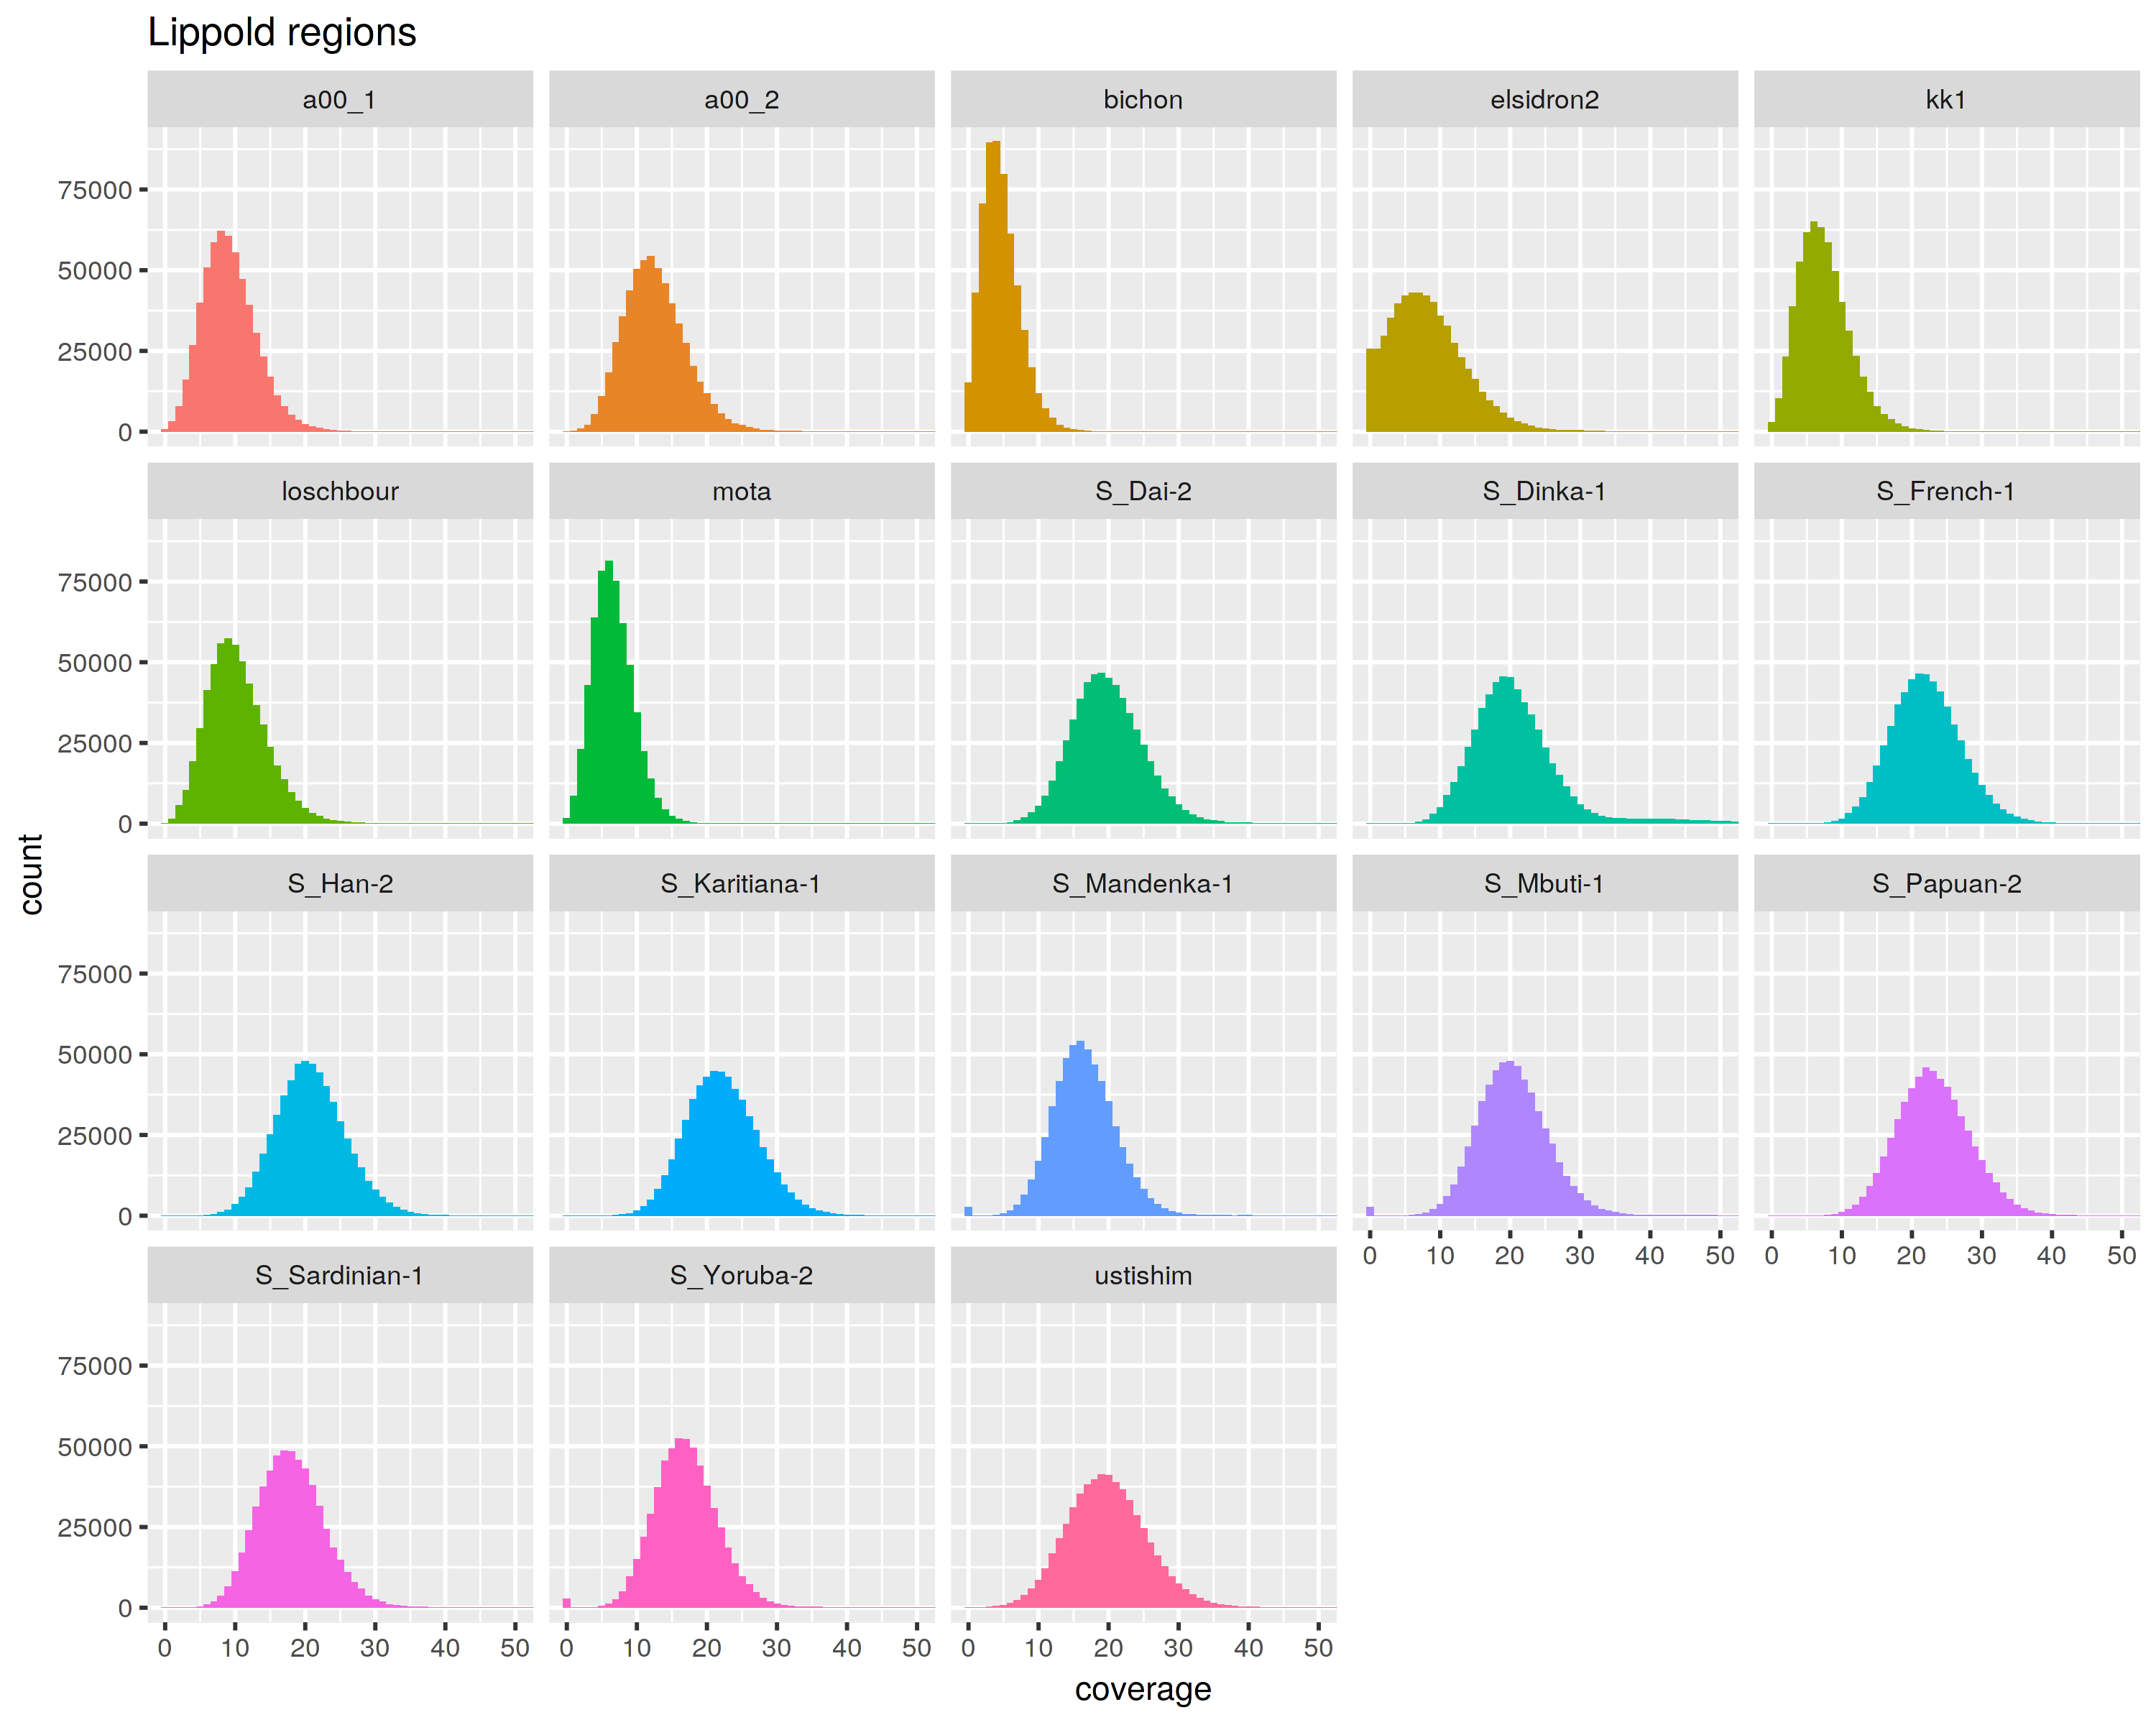

In [19]:
set_dim(10, 8, 300)

cov_df %>%
filter(regions == "lippold") %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    coord_cartesian(xlim = c(0, 50)) +
    facet_wrap(~ name) +
    theme(legend.position = "none") +
    ggtitle("Lippold regions")

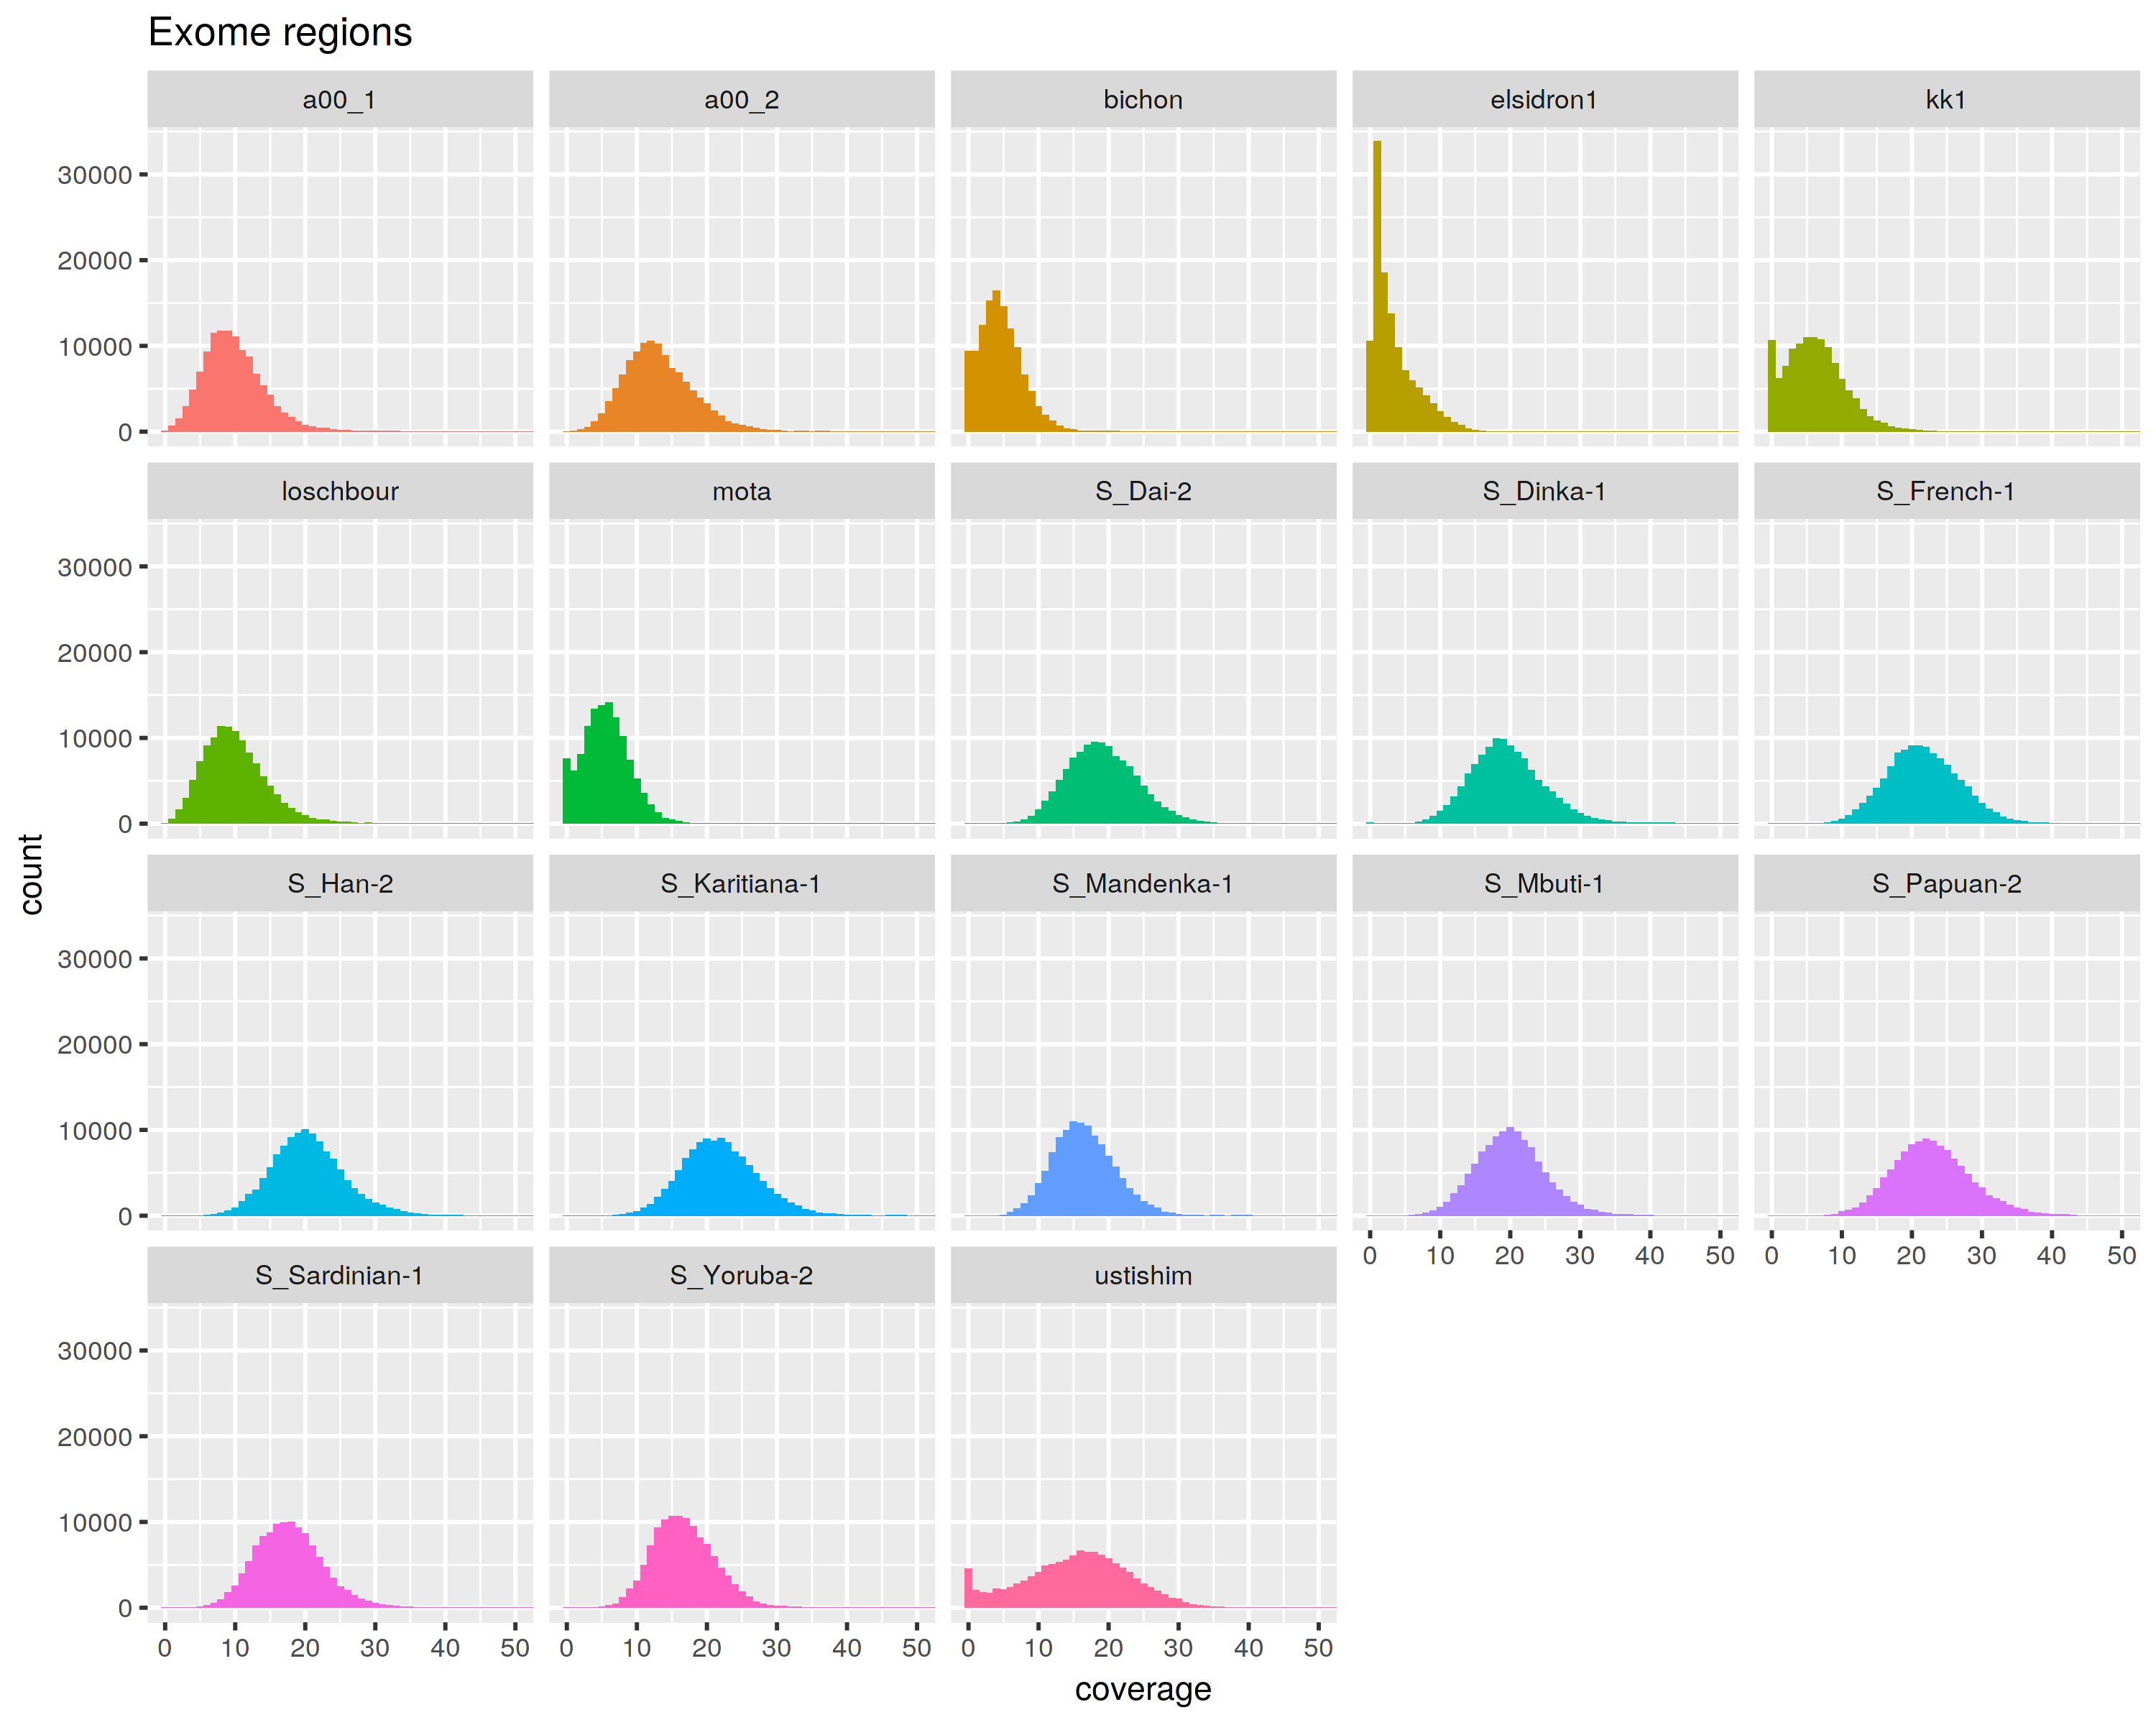

In [20]:
set_dim(10, 8, 300)

cov_df %>%
filter(regions == "exome") %>%
ggplot(aes(coverage, fill = name)) +
    geom_histogram(binwidth = 1) +
    coord_cartesian(xlim = c(0, 50)) +
    facet_wrap(~ name) +
    theme(legend.position = "none") +
    ggtitle("Exome regions")

In [21]:
x = filter(cov_df, name == "elsidron1")

In [22]:
nrow(x)

[1] 118643

In [23]:
sum(x$coverage > 0)

[1] 108115